#### Problem Statement

A scientific magazine, RealScience, believes that it's social media presence should offer a haven of truth and meaning that is easily distinguishable from the tabloid-esque style of its technology oriented competitors.

RealScience is impressed by the substantial following of r/Science at 29.1 million subscribers, and hopes to grow its social media following to similar numbers.  With proper curation and delivery of content, magazine subscriptions can be expected to increase proportionately, as this is the primary source of the company's publicity.  

To assist in the company's efforts I will use reddit data from the subreddits technology and science to determine if they are distinguishable through machine learning models.  These can then be used to identify posts from the technology subreddit that may offer insight into how best to craft a post that can have appeal to potensially receptive audiences within the world of technology enthusiasts while maintaining a scientific flavor.


Some angles: what word counts and lengths of posts, title statistics;
sentiment analysis; nlp modeling

###### Imports

In [500]:
import numpy as np
import pandas as pd
import glob
import os
import random

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (train_test_split, cross_val_predict, 
cross_val_score)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#NLP Libs
import re
import spacy
from spacy import displacy
from cleantext import clean
                                
# Lemmatizing Libs
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Visualizations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# Download if necessary: nltk.download('stopwords');

###### Import, cleaning, traint test split

In [2]:
list_of_files = glob.glob('./scitech_data_scraped/*.csv') # for inclusion of recent data
latest_file = max(list_of_files, key=os.path.getctime)

In [3]:
# run for results found in present notebook.
sci_tech_data = pd.read_csv('./scitech_data_scraped/scitech_data_2022:12:17:08:31:22-1671294682.879364.csv')

/Users/william/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17,21,34,63,68,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Drop duplicate rows.
sci_tech_data.drop_duplicates(subset = ['selftext','title'], inplace=True)

In [5]:
# Select rows with tech or science as the subreddits and save the feature space, 
# 'title' and the target, 'subreddit' to respective variables.

subreddit = sci_tech_data.loc[(sci_tech_data['subreddit'].isin(
                                ['technology','science']), 'subreddit')]
title = sci_tech_data.loc[(sci_tech_data['subreddit'].isin(
                                ['technology','science']),'title')]
# Set X and y
X = title
y = subreddit

In [6]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, 
                                                    stratify=y)
# Re-index to allow for easy splicing
(X_train.index, y_train.index, X_test.index, y_test.index) = \
(range(0, X_train.shape[0]),range(0, X_train.shape[0]), \
 range(0, X_test.shape[0]),range(0, X_test.shape[0]))

[remove stop words](https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe)

In [7]:
# add the possible giveaway words of the subreddit names to the stop words list.
stop_words = stopwords.words('english') + ['technology', 'science']
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [8]:
def filtered(data):
    '''take in data and returned data that has been filtered of punctuation, 
    digits, and urls. '''
    # replace "-" w/ 'hyphen', then remove emojis, punctuation, digits, and urls
    # while keeping an indicator or url usage.
    data_filtered = data.map(lambda x: clean(
                            re.sub('-',repl=' hyphen ', string = x) , no_emoji=True,
                                no_punct=True,no_digits=True, no_urls=True))

    # remove leftovers from the 'clean' function  

    data_filtered = data_filtered.map(lambda x: re.sub('(0|\|)',
                                                    repl='',string = x))
    #replacing hyphen with '-'
    data_filtered = data_filtered.map(lambda x: re.sub('hyphen',repl='-', string = x))
    # remove stop words   
    data_filtered = data_filtered.map(lambda x: ' '.join([word for word 
                                              in x.split() if word not in 
                                              stop_words]))
    return data_filtered

In [9]:
# instantiate filtered versions of train and test data that will be later 
# lemmatized

X_train_filtered = filtered(X_train)
X_test_filtered = filtered(X_test)

[how to get latest file](https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder)

I'll get POS counts on the raw data.
[dict to df](https://sparkbyexamples.com/python/pandas-convert-list-of-dictionaries-to-dataframe/#:~:text=The%20from_records()%20method%20is,dicts%20%2C%20or%20from%20another%20DataFrame.); 
[spacy POS tagging](https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/); [spacy POS tagging #2](https://www.geeksforgeeks.org/python-pos-tagging-and-lemmatization-using-spacy/)

###### statistics

In [10]:
# instantiate the spacy english language tokenizer.

nlp = spacy.load('en_core_web_sm')

In [11]:
def tokenize(titles):
    '''tokenize a 1d object containing strings, returning a list of the 
    tokenized sentences'''
    
    tokenized = []
    
    for title in titles:
        tokenized.append(nlp(title))
        
    return tokenized

In [12]:
# get tokenized data
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [14]:
def get_pos_features(tokenized):
    '''get the stats features that will be used in predicting, returned as a 
    sorted dictionary with keys as spacy parts of speech and fine pos tags'''
    features = []
    for tokens in tokenized:
        for token in tokens:
            # if token.pos_ not in features:
                # features.append(token.pos_)
            if token.tag_ not in features:
                features.append(token.tag_)
    return dict(zip(sorted(features),np.zeros(len(features)).astype(int)))

In [15]:
# get the parts of speech for which stats will be generated.
pos_features = get_pos_features(X_train_tokens)

In [16]:
def get_title_stats(titles, tokenized, pos_feat_dict):
    features = pos_feat_dict
    '''generate title statistics from a 1d object of title and return as a 
    DataFrame '''
    
    # Char length, word count, max and avg word length
    title_stats = pd.DataFrame()
    title_stats['title_length'] = [len(titles[i]) for i in range(len(titles))]
    title_stats['title_word_count'] = [len(titles[i].split(' ')) for \
                                        i in range(len(titles))]
    title_stats['max_word_length'] = [max(map(len, title.split(' '))) \
                         for title in titles]
    title_stats['avg_word_length'] = title_stats['title_length']/title_stats['title_word_count']
    
    # POS counts, fine pos tag counts    
    parts_of_speech = []
    for tokens in tokenized:
        pos_counts = dict(features)
        for token in tokens:
            # pos_counts[token.pos_] += 1
            pos_counts[token.tag_] += 1
        parts_of_speech.append(pos_counts)
    # combine 
    pos_df = pd.DataFrame(parts_of_speech).fillna(0)
    # pos_props_df = pos_df.iloc[:,4:].div(title_stats.title_word_count,axis=0).add_prefix("prop_")
    
    tstats_pos = pd.concat([title_stats, pos_df],axis = 1)
    return  tstats_pos

###### **Lemmatization** -- [sources](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [17]:
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/william/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[Lemmatizing w/ POS](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [18]:
# Lemmatize with POS Tag

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

To-do/idea: get POS counts [source](https://stackoverflow.com/questions/20960777/python-how-to-count-pos-tags-from-from-a-sentence)

In [19]:
lemmatizer = WordNetLemmatizer()
# Lemmatize train
X_train_lemmatized = []
for title in X_train_filtered:
    X_train_lemmatized.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for \
                               w in nltk.word_tokenize(title)]))
X_train_lemmatized = pd.Series(data = X_train_lemmatized, index = X_train_filtered.index)
X_train_lemmatized

# Lemmatize test
X_test_lemmatized = []
for title in X_test_filtered:
    X_test_lemmatized.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for \
                               w in nltk.word_tokenize(title)]))
X_test_lemmatized = pd.Series(data = X_test_lemmatized, index = X_test_filtered.index)


##### EDA

Below I will inspect various distributions of title statistics after adding the statistics to the dataframe.

In [476]:
# DataFrame from the lemmatized series
df = pd.DataFrame(X_train_lemmatized, columns = ['title']).join(pd.DataFrame(y_train))

In [477]:
df_test = pd.DataFrame(X_test_lemmatized, columns = ['title']).join(pd.DataFrame(y_train))

In [478]:
df.index = range(df.shape[0])

In [479]:
df['title_length'] = [len(df.loc[i,'title']) for i in range(len(df['title']))]

In [480]:
df['title_word_count'] = [len(df.loc[i,'title'].split(' ')) for i in range(len(df['title']))]

In [481]:
df['max_word_length'] = [max(map(len, title.split(' '))) \
                         for title in df['title']] 

In [482]:
df['avg_word_length'] = df['title_length']/df['title_word_count']

In [483]:
df['subreddit_indicator']=[1 if sub == 'technology' else 0 for sub in df['subreddit']]

In [484]:
import seaborn as sns

###### Visualizations

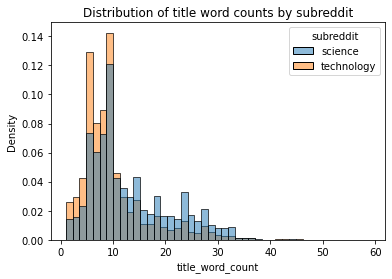

In [485]:
sns.histplot(data = df, x = 'title_word_count', hue = 'subreddit', stat='density', common_norm = False, bins = 45).set(title = 'Distribution of title word counts by subreddit')
plt.savefig('./visuals/word_count_dist')

Above we can see that shorter titles have a better chance of having been posted to technology, while longer titles are more likely from science even after accounting for baseline frequencies.

Above we see that there are many posts between 0 and 20 words long with a 

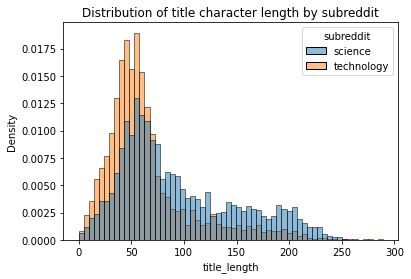

In [487]:
sns.histplot(data = df, x = 'title_length', hue = 'subreddit', stat='density', 
common_norm = False).set(title = 'Distribution of title character length by \
subreddit')
plt.savefig('./visuals/title_chars_dist')

Above we see that generally title character lengths under around 80 are more likely to have been from technology, and above 80 from science.

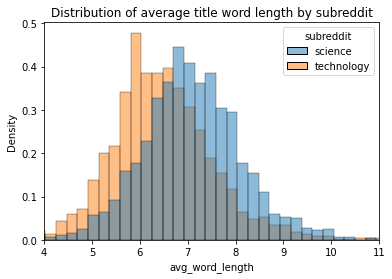

In [488]:
sns.histplot(data = df, x = 'avg_word_length', hue = 'subreddit', 
             stat='density', bins = 100, common_norm = False).set(
    title = 'Distribution of average title word length by subreddit', xlim = [4,11])
plt.savefig('./visuals/word_len_dist')

[adjusting bins](https://stackoverflow.com/questions/48990594/how-to-draw-distribution-plot-for-discrete-variables-in-seaborn)

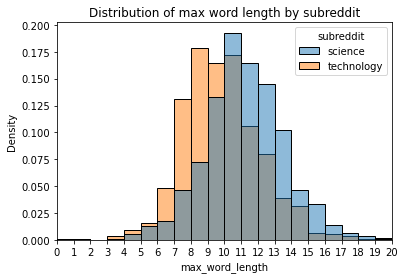

In [489]:
sns.histplot(data = df, x = 'max_word_length', hue = 'subreddit', 
             stat='density', common_norm = False, bins=np.arange(0,21)).set(
    title = 'Distribution of max word length by subreddit', xlim = [0,20], 
    xticks = range(0,21));
plt.savefig('./visuals/max_wlen_dist')

In [33]:
df.corr()

,title_length,title_word_count,max_word_length,avg_word_length,subreddit_indicator
title_length,1.000000,0.965425,0.463745,0.216842,-0.285014
title_word_count,0.965425,1.000000,0.347613,0.017029,-0.212927
max_word_length,0.463745,0.347613,1.000000,0.625348,-0.215104
avg_word_length,0.216842,0.017029,0.625348,1.000000,-0.242165
subreddit_indicator,-0.285014,-0.212927,-0.215104,-0.242165,1.000000


Above we see that word length, character count, and word counts all have some correlation with the particular subredit, though the correlation is not strong.  However, from the density plots and the clear separation in likelihoods it is apparent that valuable information would likely be picked up from a tree-based classification model.  It is promising that the title statistics gathered thus far are not fully correlated with each other as this means they can provide non-redundant information to the modeling process.

I'll next look at word count frequencies

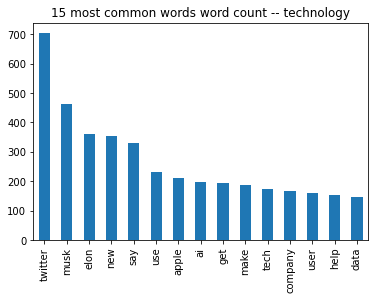

In [490]:
cv = CountVectorizer()
vectors = cv.fit_transform(df[df['subreddit']=='technology']['title'])
vectors.A
wc_vec = pd.DataFrame(vectors.A, columns = cv.get_feature_names_out())
wc_vec.sum().sort_values(ascending = False)[0:15].plot(kind = 'bar')\
.set(title = '15 most common words word count -- technology')
plt.savefig('./visuals/tech_common_words')

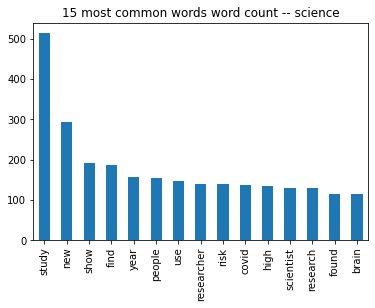

In [491]:
cv = CountVectorizer()
vectors = cv.fit_transform(df[df['subreddit']=='science']['title'])
vectors.A
wc_vec = pd.DataFrame(vectors.A, columns = cv.get_feature_names_out())
wc_vec.sum().sort_values(ascending = False)[0:15].plot(kind = 'bar')\
.set(title = '15 most common words word count -- science')

plt.savefig('./visuals/sci_common_words')

Above we see that there is not much overlap within the 15 most common words.  This indicates that there is a good chance that these common words will help with distinguishing between the subreddits.  Of note is that proper nouns seem to feature heavily in technology and almost not at all in science.

##### **Modeling**

In the modeling phase I see whether models were able to pick up differentiators in the text, text statistics, or sentiment.

###### Iterative improvement ideas

Idea: combine these fuctionalities around the text data into a class with methods.
Idea: a class that grid search optimizes functions in the background.

searching with bayesian [hyperopt](https://grabngoinfo.com/hyperparameter-tuning-for-xgboost-grid-search-vs-random-search-vs-bayesian-optimization/) is a possible further exploration

###### Baseline

In [36]:
dc = DummyClassifier()
dc.fit(X_train,y_train)
dc.score(X_test,y_test)

0.6791075050709939

The baseline model accuracy is 67.9%, which means that the most common subreddit has a 67.9% frequency in the data.  If we are able to improve upon this significantly, then the modeling process can be considered successful.

###### binary target encoding

In [37]:
# binary format for XGB target
y_train_binary = [1 if sub == 'technology' else 0 for sub in y_train]
y_test_binary = [1 if sub == 'technology' else 0 for sub in y_test]

###### modeling on statistics of the titles

What can we glean from title statistics analysis?

In [38]:
X_train_stats = get_title_stats(X_train,X_train_tokens,pos_features)
X_test_stats = get_title_stats(X_test,X_test_tokens,pos_features)

In [39]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train_stats, y_train_binary)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
xgb.score(X_train_stats, y_train_binary), xgb.score(X_test_stats, y_test_binary)

(0.9124729437229437, 0.7995943204868154)

The initial model of the score indicates substantial overfitting, so I will attempt to use random search to optimize the parameters max_depth, min_child_weight, gamma, subsample and colsample_bytree. [Control overfitting](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html)

[random search example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)

In [41]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [42]:
xgb = xgboost.XGBClassifier()
param_dist = {
              # 'booster': ['gbtree'],
              'max_depth': np.linspace(1,6, num = 6).astype(int),
              # 'min_child_weight': np.logspace(.01, 1, num = 3),
              # 'gamma': np.logspace(.01, 1, num = 5),
              # 'subsample': np.linspace(.5,1,num=4),
              'colsample_bytree': np.linspace(.1,1,num=4)
              }
n_iter_search = 15

In [43]:
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=-1
)

In [44]:
random_search.fit(X_train_stats,y_train_binary)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1, 0.4, 0.7, 1. ]),
                                        'max_depth': array([1, 2, 3, 4, 5, 6])})

In [45]:
random_search.score(X_train_stats,y_train_binary),random_search.score(X_test_stats,y_test_binary)

(0.8361742424242424, 0.7971602434077079)

In [46]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.802 (std: 0.013)
Parameters: {'max_depth': 3, 'colsample_bytree': 1.0}

Model with rank: 2
Mean validation score: 0.798 (std: 0.014)
Parameters: {'max_depth': 2, 'colsample_bytree': 0.7}

Model with rank: 3
Mean validation score: 0.798 (std: 0.014)
Parameters: {'max_depth': 4, 'colsample_bytree': 0.4}



After randomized search, while overfitting decreases there is little change in the test set performance.  As seen by the report, there are substantial attempts to reduce overfitting.  On the whole, these text statistics bring us  around 37.5% of the way to complete predictive power.

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

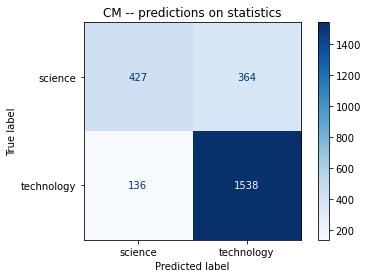

In [497]:
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test_binary, 
random_search.predict(X_test_stats)),display_labels=['science','technology'],)
cmd.plot(cmap = 'Blues')
plt.title(label = 'CM -- predictions on statistics')
plt.savefig('./visuals/cm-- predictions')

In [502]:
importance = random_search.best_estimator_.feature_importances_

In [503]:
names = random_search.best_estimator_.get_booster().feature_names

In [504]:
def feature_importance_graph(names, importance):
    df = pd.DataFrame.from_dict(dict(zip(names,importance)),columns = ['importance'], orient = 'index')
    df = df.sort_values(by = 'importance', ascending = False)
    
    sns.barplot(x = df[0:10].importance, y = df[0:10].index , color = \
                'lightblue').set(xlabel= 'Feature importance', ylabel = 'Feature', title = 'Top 10 Features by Importance')
    plt.xticks(rotation=15)
    return df

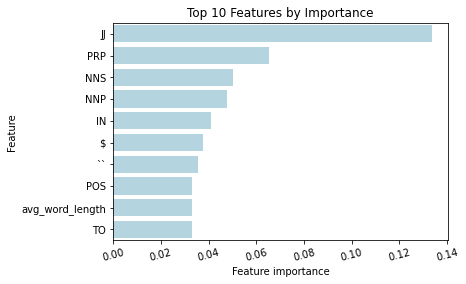

In [506]:
f_i = feature_importance_graph(names, importance)
plt.savefig('./visuals/fi-- stats')

Above, we can see that after [deciphering](https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/#:~:text=Spacy%20provides%20a%20bunch%20of,is%20most%20likely%20a%20noun.) the spacy pos tags, personal pronouns and adjectives top the list of feature importances.

I'll attempt to create a graph of the mean occurence of the most common features 

In [88]:
X_train_stats_graphing = X_train_stats
X_train_stats_graphing['subreddit'] = y_train
top_10 = X_train_stats_graphing.groupby('subreddit').mean()[f_i.index][0:10]

In [81]:
top_10.loc['sci/tech'][0:10]

JJ                 2.313713
PRP                0.444256
NNS                2.035188
NNP                0.633057
IN                 1.716416
$                  0.162096
``                 0.680693
POS                0.594487
avg_word_length    1.021284
TO                 0.747870
Name: sci/tech, dtype: float64

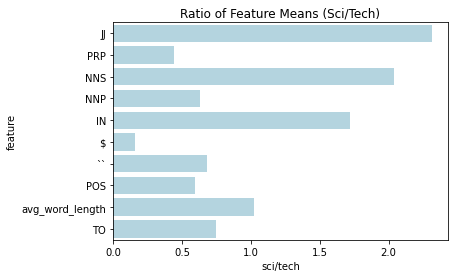

In [507]:
top_10.loc['sci/tech'] = top_10.loc['science']/top_10.loc['technology']
sns.barplot(x=top_10.loc['sci/tech'][0:10],y =top_10.columns[0:10],
            color='lightblue').set(ylabel='feature', 
                                   title = 'Ratio of Feature Means (Sci/Tech)')
plt.ylabel('feature')
plt.savefig('./visuals/stats_ratios')

Above, we see that Adjectives are more than twice as frequent in science compared to technology.

###### Modeling on the titles

In [99]:
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=1_000,
                             ngram_range=(1,2))
logreg = LogisticRegression(penalty='elasticnet', max_iter=10_000, \
                            random_state=1)

In [100]:
tfidf_lr_params = {"logreg__C": [.1,1,10],
                    "logreg__l1_ratio": [.1,.5,.9],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}

In [101]:

tfidf_lr_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('logreg', LogisticRegression(penalty='none', max_iter=10_000, random_state=33))
])

In [102]:
tfidf_lr_pipe.fit(X_train_lemmatized, y_train_binary)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg',
                 LogisticRegression(max_iter=10000, penalty='none',
                                    random_state=33))])

In [103]:
tfidf_lr_pipe.score(X_test_lemmatized, y_test_binary)

0.8567951318458418

In [104]:
gs_tfidf_lr = GridSearchCV(tfidf_lr_pipe,tfidf_lr_params)

In [106]:
gs_tfidf_lr.fit(X_train_lemmatized,y_train)

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warning

GridSearchCV(estimator=Pipeline(steps=[('tfidf_vec',
                                        TfidfVectorizer(max_features=1000,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='none',
                                                           random_state=33))]),
             param_grid={'logreg__C': [0.1, 1, 10],
                         'logreg__l1_ratio': [0.1, 0.5, 0.9],
                         'tfidf_vec__max_df': [0.9, 0.95, 1.0],
                         'tfidf_vec__min_df': [0.001, 0.003]})

In [110]:
gs_tfidf_lr.score(X_train_lemmatized,y_train), gs_tfidf_lr.score(X_test_lemmatized,y_test)

(0.9013798701298701, 0.8584178498985802)

In [109]:
gs_tfidf_lr.best_params_

{'logreg__C': 0.1,
 'logreg__l1_ratio': 0.1,
 'tfidf_vec__max_df': 0.9,
 'tfidf_vec__min_df': 0.003}


tfidf_lr_params = {"logreg__C": [.1,1,10],
                    "logreg__l1_ratio": [.1,.5,.9],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}
gs_tfidf_lr.best_params_ : {'logreg__C': 0.1,
 'logreg__l1_ratio': 0.1,
 'tfidf_vec__max_df': 0.9,
 'tfidf_vec__min_df': 0.003}
gs_tfidf_lr.score(X_test_lemmatized,y_test): 0.8584178498985802
gs_tfidf_lr.score(X_train_lemmatized,y_train): 0.9013798701298701

Above, we see that the best logistic regression model delivers reasonable improvement with text analysis over the statistics based model.

In [113]:
tfidf_xgb_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('xgb', xgboost.XGBClassifier())])
tfidf_xgb_params = {"xgb__eta": [.01,.03],
                    'xgb__booster': ['gbtree','gblinear'],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,tfidf_xgb_params)

In [ ]:
gs_tfidf_xgb.score(X_train_lemmatized,y_train_xgb),gs_tfidf_xgb.score(X_test_lemmatized,y_test_xgb)

In [114]:
gs_tfidf_xgb = GridSearchCV(tfidf_xgb_pipe,{'tfidf_vec__max_df': [0.9],
 'tfidf_vec__min_df': [0.001],
 'xgb__booster': ['gblinear'],
 'xgb__eta': [0.01]})


In [115]:
gs_tfidf_xgb.fit(X_train_lemmatized, y_train_binary)

GridSearchCV(estimator=Pipeline(steps=[('tfidf_vec',
                                        TfidfVectorizer(max_features=1000,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gam...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'tfidf_vec__max_df': [0.9],
                         'tfidf_vec__min_df': [0.001],
                         'xgb__booster': ['gblinear'], 'xgb__eta': [0.01]})

In [116]:
# gs_tfidf_xgb.fit(X_train_lemmatized,y_train_xgb)
gs_tfidf_xgb.score(X_train_lemmatized,y_train_binary),gs_tfidf_xgb.score(X_test_lemmatized,y_test_binary)

(0.9120670995670995, 0.8884381338742393)

In [ ]:
gs_tfidf_xgb.best_params_

param choices:
tfidf_xgb_params = {"xgb__eta": [.01,.03],
                    'xgb__booster': ['gbtree','gblinear'],
                   'tfidf_vec__max_df': [.9,.95,1.0],
                   'tfidf_vec__min_df': [.001,.003]}
score: 

(0.9143668831168831, 0.8892494929006085)

gs_tfidf_xgb.best_params_ :

{'tfidf_vec__max_df': 0.9,
 'tfidf_vec__min_df': 0.001,
 'xgb__booster': 'gblinear',
 'xgb__eta': 0.01}
 

So far xgboost has provided the best predictions on the test set

Above, we see that the titles have more predictive value alone than do the statistics. 

###### stacked models

In [118]:
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=1_000,
                             ngram_range=(1,2), max_df= 0.925, min_df= 0.001)

title_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('xgb', xgboost.XGBClassifier(booster= 'gblinear',eta= 0.01))])

title_pipe.fit(X_train_lemmatized, y_train_binary)
title_pipe.score(X_train_lemmatized, y_train_binary), title_pipe.score(X_test_lemmatized, y_test_binary)

(0.9117965367965368, 0.8884381338742393)

In [128]:
X_train_stats.drop(columns='subreddit', inplace= True)

In [129]:
# Fit models
rf_stats = RandomForestClassifier()

# Instantiate pipes
# stats
rf_stats.fit(X_train_stats, y_train_binary)

# title
title_pipe.fit(X_train_lemmatized, y_train_binary)

Pipeline(steps=[('tfidf_vec',
                 TfidfVectorizer(max_df=0.925, max_features=1000, min_df=0.001,
                                 ngram_range=(1, 2), stop_words='english')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.01,
                               eval_metric=None, featu...ne, gamma=None,
                               gpu_id=-1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=None, predictor=None, ...))])

In [130]:
X_pred_train = pd.DataFrame()
X_pred_train['stats'] = cross_val_predict(xgb_stats, X_train_stats, y_train_binary)
X_pred_train['title'] = cross_val_predict(title_pipe, X_train_lemmatized, y_train_binary)

In [131]:
# Level 2 model: Logistic Regression
lev2_logreg = LogisticRegressionCV()

In [133]:
lev2_logreg.fit(X_pred_train, y_train_binary)

LogisticRegressionCV()

In [135]:
lev2_logreg.score(X_pred_train,y_train_binary)

0.8434794372294372

Conclusion: this form of stacking as led to worse results than seen with just the model fitted on the title data.  I will next attempt to use a column transformer to combine the title and stats data into one dataset.

[source: strip characters from string in series](https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column)
[source: remove punctuation](https://www.google.com/search?q=how+to+replace+punctuation+with+regular+expression+python&rlz=1C5CHFA_enUS983US983&oq=how+to+replace+punctuation+with+regular&aqs=chrome.1.69i57j33i160l2.10574j0j7&sourceid=chrome&ie=UTF-8#kpvalbx=_7SabY4OANaSs0PEP042roAM_32)

###### Column transforming pipeline to generate final model

In [136]:
from sklearn.compose import ColumnTransformer

In [137]:
X_train_full = pd.concat([X_train_lemmatized.rename('title'), X_train_stats], axis = 1)
X_test_full = pd.concat([X_test_lemmatized.rename('title'), X_test_stats], axis = 1)

In [138]:
X_train_full

,title,title_length,title_word_count,max_word_length,avg_word_length,$,'',",",-LRB-,-RRB-,...,VBN,VBP,VBZ,WDT,WP,WP$,WRB,XX,_SP,``
0,prove point + - karma nothing quality post,65,13,7,5.000000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,researcher identify origin serious illness child,70,10,11,7.000000,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,way go level human need - think ai take u,95,20,8,4.750000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,former amazon exec reportedly paid $ run jeff ...,153,26,10,5.884615,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
4,iphone pro max gb alpine green - unlocked rene...,67,11,8,6.090909,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7387,supergps accurately pinpoint position within i...,85,10,12,8.500000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7388,email scrap legal - resistancephlcom,44,6,17,7.333333,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7389,amazon ceo prime video attractive economics pa...,68,10,10,6.800000,0,1,0,1,1,...,0,0,1,0,0,0,0,0,0,1
7390,possible native payment system twitter,42,6,8,7.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
from sklearn.preprocessing import PolynomialFeatures 

In [140]:
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=1000,ngram_range=(1,2))

text_transformer = tfidf_vec

numeric_transformer = Pipeline(
    steps = [('scaler',StandardScaler()),
             ('polynomial', PolynomialFeatures(degree=2, interaction_only=True))
            ]
)
text_features = 'title'
numeric_features = X_train_full.columns[1:].values

preprocessor = ColumnTransformer(
    transformers=[
    ('txt', text_transformer, text_features),
    ('num', numeric_transformer, numeric_features)
    ]
)

In [143]:
clf = Pipeline(
    steps = [('preprocessor', preprocessor), ('classifier', xgboost.XGBClassifier(booster = 'gblinear', eta = .01))]
)
clf.fit (X_train_full, y_train_binary)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('txt',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  array(['title_length', 'title_word_count', 'max_word_length',
       'avg_word_length', '$', "''",...
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=-1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=0, num_parallel_tree=None, predictor=None, ...))])

In [144]:
clf.score(X_train_full,y_train_binary), clf.score(X_test_full,y_test_binary)

(0.9327651515151515, 0.8888438133874239)

After all this effort, my model is performing no better than the xgboost model on the tfidf transformed text data.  My Final attempt at improving my baseline will be by looking at sentiment analysis.

In [145]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk

nltk.download('wordnet') # WordNet is a lexical database of English. Using synsets, helps find conceptual relationships between words such as hypernyms, hyponyms, synonyms, antonyms etc. 

nltk.download('omw-1.4') # Open Multilingual Wordnet ("OMW")

nltk.download('vader_lexicon') # sentiment (positive, negative, etc.) lexicon

[nltk_data] Downloading package wordnet to /Users/william/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/william/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/william/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [146]:
sia = SentimentIntensityAnalyzer()

In [147]:
X_train_polar = np.zeros(len(X_train))
X_train_polar = pd.DataFrame([sia.polarity_scores(text) for text in X_train])
X_test_polar = pd.DataFrame([sia.polarity_scores(text) for text in X_test])

In [149]:
from sklearn.neighbors import KNeighborsClassifier

I might expect that the limited feature space and similar scaling of the features would allow for reasonable performance by knn.

In [151]:
knn = KNeighborsClassifier()
knn.fit(X_train_polar, y_train_binary)
knn.score(X_train_polar, y_train_binary), knn.score(X_test_polar, y_test_binary)

(0.728219696969697, 0.6681541582150101)

Knn does not perform well, with a test score below baseline of 0.668

In [154]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train_polar, y_train_binary)
xgb.score(X_train_polar, y_train_binary), xgb.score(X_test_polar, y_test_binary)

(0.7698863636363636, 0.6851926977687627)

Sentiment analysis provides a paltry improvement over baseline.  However, looking at the average sentiment may be useful in guiding the social media team.

In [183]:
polar_df = X_train_polar.copy()
polar_df['subreddit'] = y_train
pd.set_option('display.max_columns', None)
polar_df[['neg','pos','subreddit']].groupby('subreddit').describe()


neg                                                      pos  \
             count      mean       std  min  25%  50%    75%    max   count   
subreddit                                                                     
science     2374.0  0.073698  0.117066  0.0  0.0  0.0  0.131  0.624  2374.0   
technology  5018.0  0.065869  0.120051  0.0  0.0  0.0  0.106  0.796  5018.0   

                                                           
                mean       std  min  25%  50%    75%  max  
subreddit                                                  
science     0.080226  0.117385  0.0  0.0  0.0  0.143  1.0  
technology  0.093371  0.140888  0.0  0.0  0.0  0.172  1.0

Above, we see that both technology and science are quite neutral in sentiment, which explains the negligible predictive power of sentiment.  I'll include anyways, as I don't believe they will result in significant overfitting and better parameter selection may eek out some value

In [216]:
#debug axs plotting error "parg follows kwarg"

# plt.figure(figsize=(20,20))
# fig, axs = plt.subplots(2,2)
# sns.displot(polar_df.loc[(polar_df['neg']> polar_df.loc[
#     polar_df['subreddit']=='science','neg'].quantile(.75))
#     &(polar_df['subreddit']=='science'),'neg']) #ax = axs[0,0]
# .set(title = 'Science negativity distribution above 75th percentile')
# sns.displot(ax = axs[0,1],polar_df.loc[(polar_df['neg']> polar_df.loc[polar_df['subreddit']==
# 'technology','neg'].quantile(.75))&(polar_df['subreddit']=='technology'),'neg']
#     ).set(title = 'Technology negativity distribution above 75th percentile')

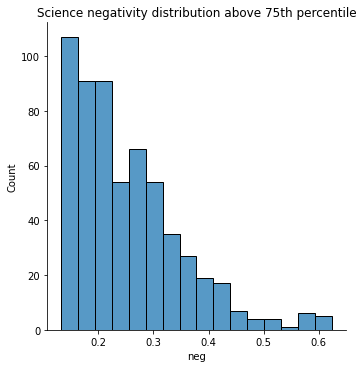

In [508]:
sns.displot(polar_df.loc[(polar_df['neg']> polar_df.loc[polar_df['subreddit']==
'science','neg'].quantile(.75))&(polar_df['subreddit']=='science'),'neg']).set(
    title = 'Science negativity distribution above 75th percentile')
plt.savefig('./visuals/sia_neg_sci')

<Figure size 720x720 with 0 Axes>

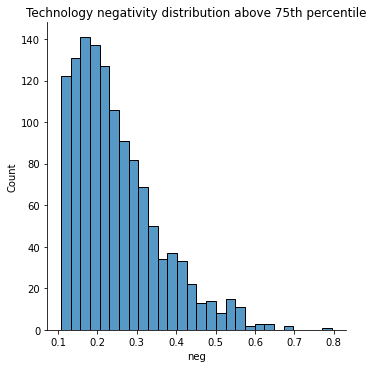

In [510]:
plt.figure(figsize=(10,10))
sns.displot(polar_df.loc[(polar_df['neg']> polar_df.loc[polar_df['subreddit']==
'technology','neg'].quantile(.75))&(polar_df['subreddit']=='technology'),'neg']
    ).set(title = 'Technology negativity distribution above 75th percentile')
plt.savefig('./visuals/sia_neg_tec')

Above, we see that the negative sentiment distributions are very similar between both science and technology.

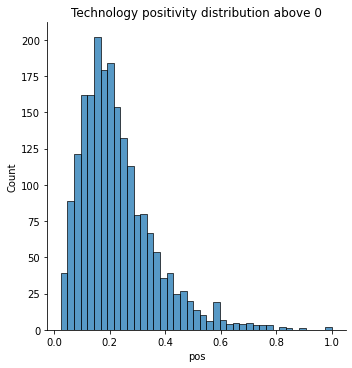

In [200]:
sns.displot(polar_df.loc[(polar_df['pos']> 0)&(polar_df['subreddit']=='technology'),'pos']
    ).set(title = 'Technology positivity distribution above 0')

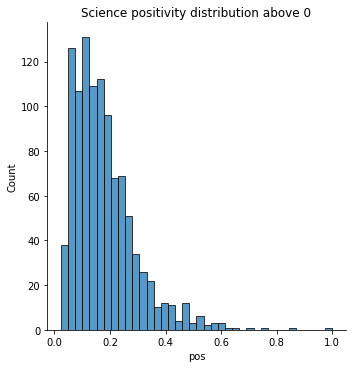

In [202]:
sns.displot(polar_df.loc[(polar_df['pos']> 0)&(polar_df['subreddit']=='science'),'pos']
    ).set(title = 'Science positivity distribution above 0')

Above, we see that the positive sentiment of science is slighly more muted than with technology.

In [ ]:
tfidf_xgb_pipe = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('xgb', xgb.XGBClassifier(seed = 1))])
tfidf_xgb_params = {"xgb__eta": [.01,.015,.05],
                    'xgb__booster': ['gbtree','gblinear'],
                    # 'xgb__lambda': [.1,1,10],
                    # 'xgb__alpha': [0,.1,1],
                   'tfidf_vec__max_df': [.85,.9,.925],
                   'tfidf_vec__min_df': [.0005,.001,.0015],}


###### Grid search over text, stats, and sentiment

In [169]:
text_transformer = TfidfVectorizer(stop_words='english', max_features=1000)

numeric_transformer = Pipeline(
    steps = [('scaler',StandardScaler())
             # ('polynomial', PolynomialFeatures(degree=2, interaction_only=True))
            ]
)

text_features = 'title'
numeric_features = X_train_full2.columns[1:].values

preprocessor = ColumnTransformer(
    transformers=[
    ('txt', text_transformer, text_features),
    ('num', numeric_transformer, numeric_features)
    ]
)

In [170]:
full_pipe = Pipeline(
    steps = [('preprocessor', preprocessor), ('classifier', xgboost.XGBClassifier(max_depth=6))]
)

In [171]:
params = {'preprocessor__txt__max_df':[.9,.925],
          'preprocessor__txt__min_df': [.0001,.0005],
          'preprocessor__txt__ngram_range': [(1, 2),(1, 3)],
          'classifier__subsample': [.78,.8],
         }

In [172]:
gs_full = GridSearchCV(full_pipe, params)

gs_full.fit(X_train_full2, y_train_binary)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('txt',
                                                                         TfidfVectorizer(max_features=1000,
                                                                                         stop_words='english'),
                                                                         'title'),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         array(['title_length', 'title_word_count', 'max_word_length',
       'avg_word_length', '$', "''", ',', '-LRB-', '-RRB-', '.', ':',
       'ADD', 'AFX', 'CC', 'CD', 'D...
                                                      max_depth=6,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__subsample': [0.78, 0.8],
                         'preprocessor__txt__max_df': [0.9, 0.925],
                         'preprocessor__txt__min_df': [0.0001, 0.0005],
                         'preprocessor__txt__ngram_range': [(1, 2), (1, 3)]})

In [174]:
gs_full.best_params_

{'classifier__subsample': 0.8,
 'preprocessor__txt__max_df': 0.9,
 'preprocessor__txt__min_df': 0.0001,
 'preprocessor__txt__ngram_range': (1, 3)}

In [173]:
gs_full.score(X_train_full2,y_train_binary),gs_full.score(X_test_full2,y_test_binary)

(0.9277597402597403, 0.8713995943204869)

gs_full.best_params_ : {'classifier__subsample': 0.8,
 'preprocessor__txt__max_df': 0.9,
 'preprocessor__txt__min_df': 0.0001,
 'preprocessor__txt__ngram_range': (1, 3)}
gs_full.score(X_train_full2,y_train_binary),gs_full.score(X_test_full2,y_test_binary): (0.9277597402597403, 0.8713995943204869)

Now I will plug in the best previously found parameters for the classifier

In [217]:
params = {'preprocessor__txt__max_df':[.9],
          'preprocessor__txt__min_df': [.001],
          'preprocessor__txt__ngram_range': [(1, 2),(1, 3)],
          'classifier__eta': [.01],
          'classifier__booster': ['gblinear'],
         }

In [218]:
gs_full = GridSearchCV(full_pipe, params)

gs_full.fit(X_train_full2, y_train_binary)

[03:56:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[03:56:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[03:56:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[03:56:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[03:56:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[03:56:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('txt',
                                                                         TfidfVectorizer(max_features=1000,
                                                                                         stop_words='english'),
                                                                         'title'),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         array(['title_length', 'title_word_count', 'max_word_length',
       'avg_word_length', '$', "''", ',', '-LRB-', '-RRB-', '.', ':',
       'ADD', 'AFX', 'CC', 'CD', 'D...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__booster': ['gblinear'],
                         'classifier__eta': [0.01],
                         'preprocessor__txt__max_df': [0.9],
                         'preprocessor__txt__min_df': [0.001],
                         'preprocessor__txt__ngram_range': [(1, 2), (1, 3)]})

In [221]:
gs_full.score(X_train_full2,y_train_binary),gs_full.score(X_test_full2,y_test_binary)

(0.9154491341991342, 0.8920892494929006)

In [222]:
gs_full.best_params_

{'classifier__booster': 'gblinear',
 'classifier__eta': 0.01,
 'preprocessor__txt__max_df': 0.9,
 'preprocessor__txt__min_df': 0.001,
 'preprocessor__txt__ngram_range': (1, 2)}

The best score thus far has been achieved!  We have eked out a .0032 gain in test set accuracy and .0037 in trainin set accuracy, bringing us to 0.892 in test set performance.  

In [ ]:
.0036

In [285]:
params_eta_tune = {'preprocessor__txt__max_df':[.9],
          'preprocessor__txt__min_df': [.001],
          'preprocessor__txt__ngram_range': [(1, 2),(1, 3)],
          'classifier__eta': [.0115],
          'classifier__booster': ['gblinear'],
         }

In [286]:
gs_full = GridSearchCV(full_pipe, params_eta_tune)

gs_full.fit(X_train_full2, y_train_binary);

[04:15:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:15:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:15:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.maco

In [287]:
gs_full.score(X_train_full2,y_train_binary),gs_full.score(X_test_full2,y_test_binary)

(0.9189664502164502, 0.8933062880324544)

Further tuning of the eta has lead to an additional 13 tenths of test set performance, which ammounts to around three additional correct predictions on the test set of 2465 observations.  It is quite possible that this further 'test' set improvement is due to overtuning of the eta hyper parameter.  However, I believe that the model is performing as well as it could in terms of accuracy and that it is ready to categorize truly new technology and science subreddit posts.

The final parameters are:

```{'classifier__booster': 'gblinear',
 'classifier__eta': 0.0115,
 'preprocessor__txt__max_df': 0.9,
 'preprocessor__txt__min_df': 0.001,
 'preprocessor__txt__ngram_range': (1, 2)}```

I will now investigate various characteristic of the model. 

###### Results analysis

In [293]:
# predictions on test set:
pred_test = gs_full.predict(X_test_full2)

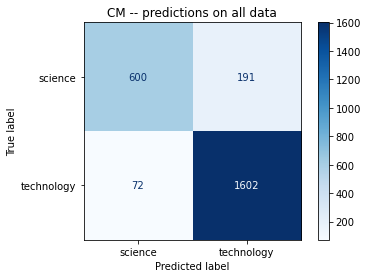

In [512]:
cm = confusion_matrix(y_test_binary, pred_test)

cmd = ConfusionMatrixDisplay(cm,display_labels=['science','technology'],)
cmd.plot(cmap = 'Blues')
plt.title(label = 'CM -- predictions on all data')
plt.savefig('./visuals/cm--full_model_predictions')

In the square above, we have true positives in the lower right, true negatives in the upper left, false positives in the upper right, and false negatives in the lower left.  A 'positive' outcome is a technology prediction and a 'negative' outcome is a science prediction.

In [308]:
cm[0,1]

191

In [315]:
# Accuracy: (tp+tn)/(tp+tn+fp+fn)
(cm[0,0] + cm[1,1])/cm.sum()*100 # Accuracy is 89.33%, 

89.33062880324543

In [317]:
# Precision: tp/(tp+fp)
(cm[1,1])/((cm[0,1] + cm[1,1]))*100 # Precision is 89.35%

89.34746235359732

In [318]:
# Recall/sensitivity: tp/(tp+fn)
(cm[1,1])/(cm[1,0] + cm[1,1])*100 # Recall is 95.70%

0.956989247311828

In [322]:
# Specificity: tn/(tn+fp)
(cm[0,0])/((cm[0,0] + cm[0,1]))*100 # Specificity is 75.85%

75.85335018963337

In [323]:
# F1 score:

(2*cm[1,1])/(2*cm[1,1] + cm[0,1] + cm[1,0]) # F1 score is .9241

0.9241419094317854

Above, we find that accuracy is 89.33%, precision is 89.35%, recall/sensitivity is 95.70%, specificity is 75.85%, and the F1 score is .9241.  These are promising results that demostrate the model is offering value in correctly identifying both subreddits.  Most relevant to our goal of finding technology posts that appear scientific, 72/672 of the posts predicted to be scientific were in fact from the technology subreddit.

Now lets examine technology posts that pass as 'scientific'.

In [ ]:
pred_test

In [335]:
type(X_test)

pandas.core.series.Series

In [351]:
y

array([0, 1, 0, ..., 1, 1, 1])

In [364]:
false_negatives = X_test.loc[(pred_test==0) &  (np.array(y_test_binary)==1)]

In [404]:
false_positives = X_test.loc[(pred_test==1) &  (np.array(y_test_binary)==0)]

In [394]:
random.seed(a=30, version=2)
fn_sample = false_negatives.iloc[random.sample(list(np.linspace(0,72,73).astype(int)),5,)]

In [403]:
fn_sample.iloc[4]

'Brain cancer vaccine succeeds at prolonging survival in Phase 3 trial'

A sample of five posts incorrectly identified as science are :

1) 'U.S. officials announce major nuclear fusion breakthrough | [36:50]'
2) "Musk's Neuralink intends to implant coin-sized computer brain implants into human patients within the next six months",
3) "Deep-learning system identifies difficult-to-detect brain metastases"
4) 'News Updates:Indian stocks recover losses as banks and metals offset a decline in IT.'
5) 'Brain cancer vaccine succeeds at prolonging survival in Phase 3 trial'


From examining the above technology posts which were falsely identified as scientific, it is apparent that there is a scientific presence within the r/technology community.  

The model is understandably having difficulty with the important intersection between science and technology, with reports of cutting edge technological advancements (Fusion, brain implants, vaccines) being identified as posts by the r/science community.  

The lone pure-business post about indian stocks represents potential for model improvement.

Now lets inspect a few false positive predictions, which falsely identify science posts as technological.

In [405]:
false_positives = X_test.loc[(pred_test==1) &  (np.array(y_test_binary)==0)]

In [412]:
random.seed(a=30, version=2)
fp_sample = false_positives.iloc[random.sample(list(np.linspace(0,72,73).astype(int)),5,)]

In [430]:
for i in [0,1,2,3,4]:
    print(fp_sample.iloc[i])

Scientists Have Found a Way To Manipulate Digital Data Stored in DNA
Biomaterials for enhanced immunotherapy
Unique gravity defying technology 👌
A quantum computer has simulated a wormhole for the first time
Where Have All the Snow Crabs Gone?


The above sample of posts incorrectly identified as technological demostrate both the technological concern and conversational style of some science posts.  This indicates to me that there is some place for colloquial tone and reporting on developments that are part technological in nature within the context of scientific reporting.

In [513]:
importance = gs_full.best_estimator_.named_steps.classifier.feature_importances_

In [514]:
names_txt = gs_full.best_estimator_.named_steps.preprocessor.named_transformers_.txt.get_feature_names_out()
names_num = gs_full.best_estimator_.named_steps.preprocessor.named_transformers_.num.get_feature_names_out()
names = np.concatenate((names_txt,names_num))
names = names.tolist()

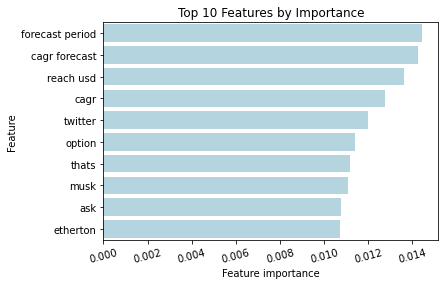

In [515]:
feature_importance_graph(names,importance)

plt.savefig('./visuals/fi_full_model')

Above, we see that the bigram 'forecast period' has the greatest importance in the model.  Other business terms also show some importance, as do the late 2022 treding topics of 'twitter' and 'musk'. 

#### Conclusions, Recommendations, and Next Steps

The findings of this report demonstrate that is is possible for a model to distinguish, with substantial improvement over the baseline, between posts from the science and technology subreddits.

The model has also demonstrated that there is significant overlap between the science and technology subreddits, with around 25% of the scientific posts being classified as technological and around 5% of the technological posts being classified as scientific.  The difference in these misclassification magnitudes is likely due in part to the unbalanced priors of the classes, with around 68% of the posts being from the technology subreddit. Upon inspecting examples of these misclassifications, it became clear that many of the posts from technology that were classified as scientific were in fact highly scientific in nature.

The takeaway is that a technological tilt would not be amiss in RealScience's social media presence.  While this is not surprising, these findings offer that audiences appreciate findings that intertwine technological and scientific elements.